In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse

In [3]:
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.layers.advanced_activations import LeakyReLU, PReLU

Using TensorFlow backend.


In [4]:
# REQUIRED FUNCTION

def shift(df, obj, step=1):
    '''
    '''
    df = pd.concat([df.shift(step), df[obj]], axis=1)
    df = df.dropna()
#     df = df.sample(df.shape[0])
    df = df.values
#     time = df[:, 0]
    X, y = df[:, :-1], df[:, -1]
    return X, y

def scale(train, valid, feature_range=(0, 1)):
    '''
    '''
    scaler = MinMaxScaler(feature_range=feature_range)
    scaler.fit(train)
    
    train_scaled = scaler.transform(train)
    valid_scaled = scaler.transform(valid)
    
    return scaler, train_scaled, valid_scaled

def inverse(scaler, fea, y_pred):
    '''
    '''
    array    = np.c_[fea, y_pred]
    inverted = scaler.inverse_transform(array)
    return inverted[:, -1]

def to_DF(col_name, *args):
    '''
    '''
    assert len(args) != 0, "There are no input data."
    
    df_list = list()
    for arg in args:
        df = pd.DataFrame(data=arg, columns = col_name)
        df_list.append(df)

    return df_list

def MASE(pred, target, orig):
    '''
    '''
    n     = len(target)
    MAE   = np.mean(sum(np.abs(target - pred)))
    MAE_n = np.mean(sum(np.abs(target - orig)))
    e     = MAE / ((n + 1) * MAE_n / n)
    return e

def MAPE(pred, orig):
    '''
    '''
    e = np.mean(np.abs((orig - pred)/orig))
    return e

In [2]:
w3 = pd.read_csv('w3-cali.csv')
w3['date'] = pd.to_datetime(w3['date'])
w = w3.drop(['date'], axis=1)

mtrain, mtest = w[:200], w[200:]

In [3]:
des = w3.describe()
des.to_csv("w3-describe.csv")

## WHFT

In [6]:
scaler, train, test = scale(mtrain, mtest)
cols = w.columns
df = to_DF(cols, train, test)
train, test = df[0], df[1]
print(train.shape, test.shape)

(200, 6) (64, 6)


In [7]:
X_tr1, y_tr1 = shift(train, 'whft', step=1)
X_te1, y_te1 = shift(test, 'whft', step=1)
print(X_tr1.shape, y_tr1.shape, X_te1.shape, y_te1.shape)

(199, 6) (199,) (63, 6) (63,)


In [8]:
vf_whft = test.values[-1].reshape((1, -1))
vf_whft

array([[0.33526803, 0.32768362, 0.5311395 , 0.21085791, 0.27104058,
        0.65462428]])

In [24]:
m1 = Sequential()
m1.add(Dense(7, input_shape=(6, ), activation='relu'))
# m1.add(LeakyReLU(alpha=0.001))
m1.add(Dense(1))
m1.compile(loss='mse', optimizer='adam')

In [25]:
epochs = 60

h1 = m1.fit(X_tr1, y_tr1, 
             epochs=epochs,
             batch_size=6)

Epoch 1/60
199/199 [==============================] - 0s 2ms/step - loss: 0.0606
Epoch 2/60
199/199 [==============================] - 0s 427us/step - loss: 0.0443
Epoch 3/60
199/199 [==============================] - 0s 357us/step - loss: 0.0348
Epoch 4/60
199/199 [==============================] - 0s 347us/step - loss: 0.0290
Epoch 5/60
199/199 [==============================] - 0s 362us/step - loss: 0.0252
Epoch 6/60
199/199 [==============================] - 0s 331us/step - loss: 0.0222
Epoch 7/60
199/199 [==============================] - 0s 331us/step - loss: 0.0203
Epoch 8/60
199/199 [==============================] - 0s 341us/step - loss: 0.0191
Epoch 9/60
199/199 [==============================] - 0s 336us/step - loss: 0.0181
Epoch 10/60
199/199 [==============================] - 0s 347us/step - loss: 0.0172
Epoch 11/60
199/199 [==============================] - 0s 291us/step - loss: 0.0166
Epoch 12/60
199/199 [==============================] - 0s 347us/step - loss: 0.0160
Epo

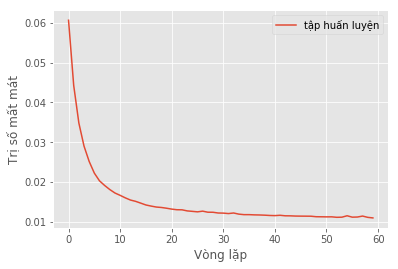

In [26]:
plt.plot(h1.history['loss'], label="tập huấn luyện")
plt.xlabel('Vòng lặp')
plt.ylabel('Trị số mất mát')
plt.legend()
plt.show()

In [27]:
loss = pd.DataFrame({'epochs': range(1, epochs+1),
                     'loss': h1.history['loss']})
loss.to_csv('w3-whft-loss.dat', index=False)

In [28]:
whft = m1

y_train_pred = whft.predict(X_tr1)
y_test_pred = whft.predict(X_te1)

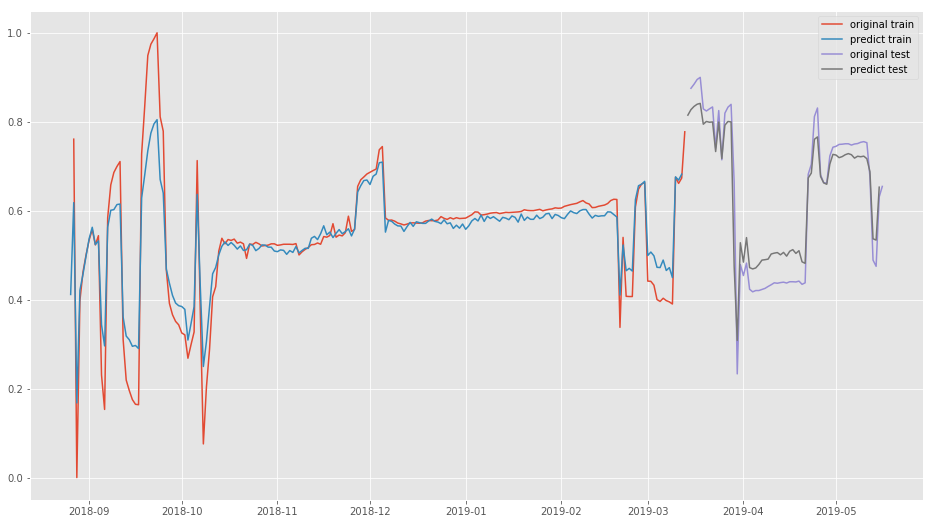

In [29]:
plt.figure(figsize=(16, 9))
plt.plot(w3['date'][1:200], y_tr1,        label='original train')
plt.plot(w3['date'][:199], y_train_pred, label='predict train')
plt.plot(w3['date'][201:], y_te1,         label='original test')
plt.plot(w3['date'][200:-1], y_test_pred,   label='predict test')
plt.legend()
plt.show()

In [30]:
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_test_pred, y_te1), MAPE(y_test_pred, y_te1)))

MSE: 0.0061 | MAPE: 0.3265


In [31]:
whft.save('whft-loss-0.0061.hdf5')

In [32]:
# whft = load_model('whft-loss-0.0119.hdf5')

y_train_pred = whft.predict(X_tr1)
y_test_pred = whft.predict(X_te1)

y_hat = inverse(scaler, X_te1[:, :-1], y_test_pred)
y_train_hat = inverse(scaler, X_tr1[:, :-1], y_train_pred)

In [37]:
predict_train_set = pd.DataFrame({'date': w3['date'][1:200].values,
                                  'orig': mtrain['whft'][1:200].values,
                                  'pred': y_train_hat})

predict_test_set = pd.DataFrame({'date': w3['date'][201:].values,
                                 'orig': mtest['whft'][1:].values,
                                 'pred': y_hat})

predict_train_set.to_csv('whft_train.dat', index=False)
predict_test_set.to_csv('whft_test.dat', index=False)

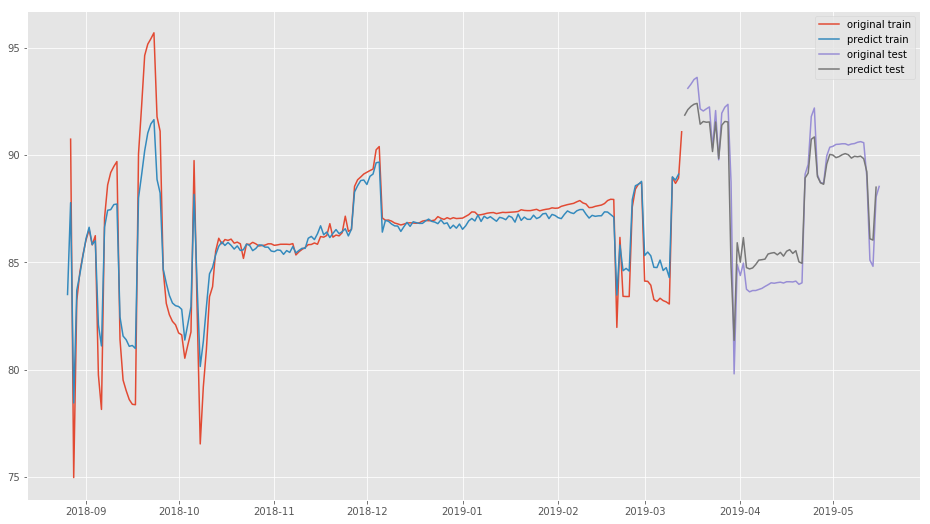

In [33]:
plt.figure(figsize=(16, 9))
plt.plot(w3['date'][1:200], mtrain['whft'][1:200], label='original train')
plt.plot(w3['date'][:199], y_train_hat, label='predict train')
plt.plot(w3['date'][201:],  mtest['whft'][1:], label='original test')
plt.plot(w3['date'][200:-1],  y_hat, label='predict test')
plt.legend()
plt.show()

In [35]:
m = inverse(scaler, X_te1[:, :-1], y_te1)

In [36]:
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_hat, m), MAPE(y_hat, m)))

MSE: 2.6093 | MAPE: 0.0149


## WHFP

In [38]:
train1 = pd.concat([mtrain.drop(['whfp'], axis=1), mtrain['whfp']], axis=1)
test1 = pd.concat([mtest.drop(['whfp'], axis=1), mtest['whfp']], axis=1)

In [39]:
scaler, train, test = scale(train1, test1)
cols = train1.columns
df = to_DF(cols, train, test)
train, test = df[0], df[1]
print(train.shape, test.shape)

(200, 6) (64, 6)


In [40]:
X_tr2, y_tr2 = shift(train, 'whfp', step=1)
X_te2, y_te2 = shift(test, 'whfp', step=1)
print(X_tr2.shape, y_tr2.shape, X_te2.shape, y_te2.shape)

(199, 6) (199,) (63, 6) (63,)


In [41]:
vf_whfp = test.values[-1].reshape((1, -1))
vf_whfp

array([[0.33526803, 0.32768362, 0.5311395 , 0.21085791, 0.65462428,
        0.27104058]])

In [78]:
m2 = Sequential()
m2.add(Dense(7, input_shape=(6, ), activation='linear'))
m2.add(LeakyReLU(alpha=0.001))
m2.add(Dense(1))
m2.compile(loss='mse', optimizer='adam')

In [79]:
epochs=55

h2 = m2.fit(X_tr2, y_tr2, 
             epochs=epochs,
             batch_size=4)

Epoch 1/55
199/199 [==============================] - 1s 4ms/step - loss: 0.0612
Epoch 2/55
199/199 [==============================] - 0s 512us/step - loss: 0.0163
Epoch 3/55
199/199 [==============================] - 0s 578us/step - loss: 0.0143
Epoch 4/55
199/199 [==============================] - 0s 593us/step - loss: 0.0129
Epoch 5/55
199/199 [==============================] - 0s 527us/step - loss: 0.0117
Epoch 6/55
199/199 [==============================] - 0s 497us/step - loss: 0.0106
Epoch 7/55
199/199 [==============================] - 0s 497us/step - loss: 0.0100
Epoch 8/55
199/199 [==============================] - 0s 537us/step - loss: 0.0089
Epoch 9/55
199/199 [==============================] - 0s 527us/step - loss: 0.0083
Epoch 10/55
199/199 [==============================] - 0s 542us/step - loss: 0.0076
Epoch 11/55
199/199 [==============================] - 0s 517us/step - loss: 0.0072
Epoch 12/55
199/199 [==============================] - 0s 507us/step - loss: 0.0067
Epo

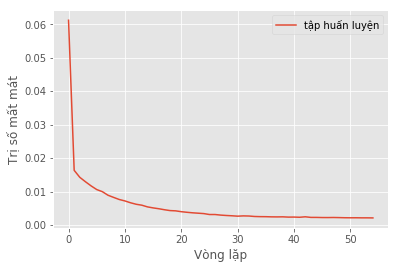

In [80]:
plt.plot(h2.history['loss'], label="tập huấn luyện")
plt.xlabel('Vòng lặp')
plt.ylabel('Trị số mất mát')
plt.legend()
plt.show()

In [81]:
loss = pd.DataFrame({'epochs': range(1, epochs+1),
                     'loss': h2.history['loss']})
loss.to_csv('w3-whfp-loss.dat', index=False)

In [82]:
whfp = m2

y_train_pred = whfp.predict(X_tr2)
y_test_pred = whfp.predict(X_te2)

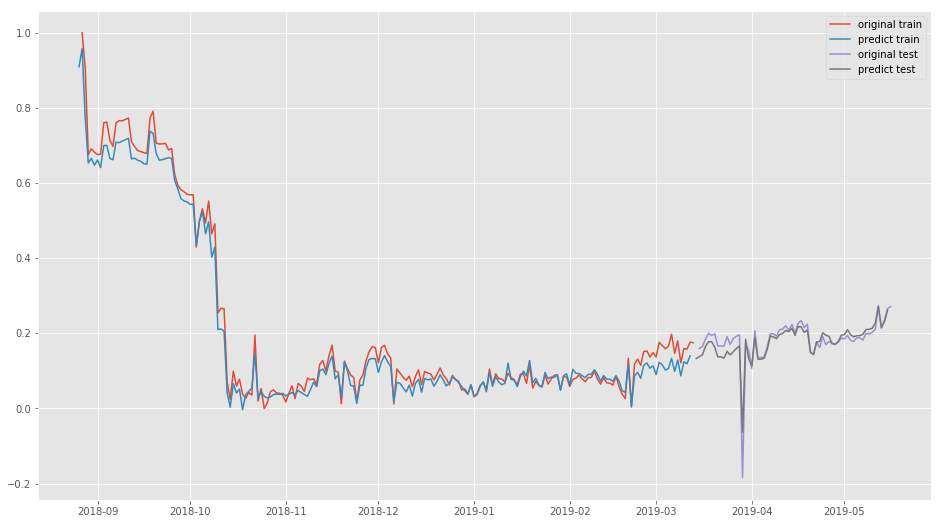

In [83]:
plt.figure(figsize=(16, 9))
plt.plot(w3['date'][1:200], y_tr2, label='original train')
plt.plot(w3['date'][:199], y_train_pred, label='predict train')
plt.plot(w3['date'][201:], y_te2, label='original test')
plt.plot(w3['date'][200:-1], y_test_pred, label='predict test')
plt.legend()
plt.show()

In [84]:
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_test_pred, y_te2), MAPE(y_test_pred, y_te2)))

MSE: 0.0036 | MAPE: 0.2401


In [89]:
whfp.save('whfp-loss-0.0036.hdf5')

In [85]:
# whfp = load_model('whfp-loss-0.0053.hdf5')

y_train_pred = whfp.predict(X_tr2)
y_test_pred = whfp.predict(X_te2)

y_hat = inverse(scaler, X_te2[:, :-1], y_test_pred)
y_train_hat = inverse(scaler, X_tr2[:, :-1], y_train_pred)

In [90]:
predict_train_set = pd.DataFrame({'date': w3['date'][1:200].values,
                                  'orig': mtrain['whfp'][1:200].values,
                                  'pred': y_train_hat})

predict_test_set = pd.DataFrame({'date': w3['date'][201:].values,
                                 'orig': mtest['whfp'][1:].values,
                                 'pred': y_hat})

predict_train_set.to_csv('whfp_train.dat', index=False)
predict_test_set.to_csv('whfp_test.dat', index=False)

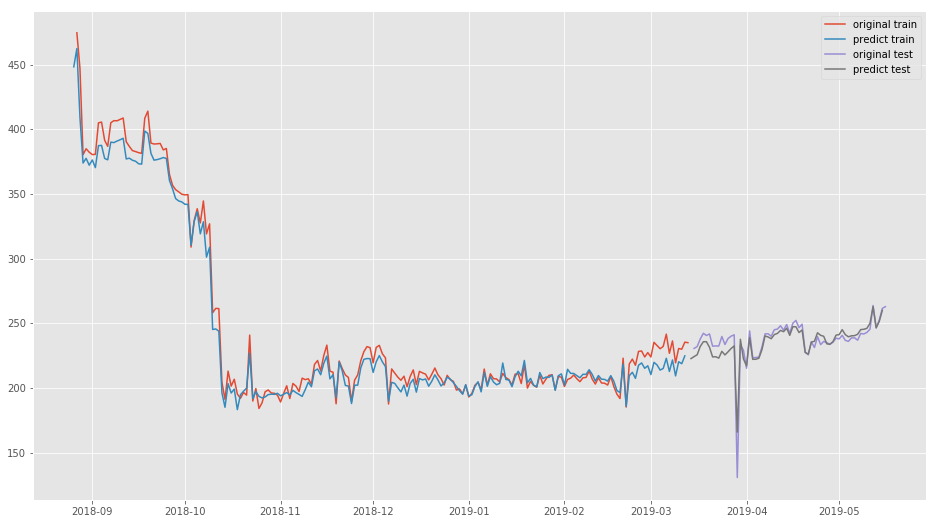

In [91]:
plt.figure(figsize=(16, 9))
plt.plot(w3['date'][1:200], mtrain['whfp'][1:200], label='original train')
plt.plot(w3['date'][:199], y_train_hat, label='predict train')
plt.plot(w3['date'][201:], mtest['whfp'][1:], label='original test')
plt.plot(w3['date'][200:-1], y_hat, label='predict test')
plt.legend()
plt.show()

In [87]:
m = test1['whfp'][:-1].values

In [88]:
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_hat, m), MAPE(y_hat, m)))

MSE: 43.6532 | MAPE: 0.0208


## WATER RATE

In [93]:
train2 = pd.concat([mtrain.drop(['q_water'], axis=1), mtrain['q_water']], axis=1)
test2 = pd.concat([mtest.drop(['q_water'], axis=1), mtest['q_water']], axis=1)

In [94]:
scaler, train, test = scale(train2, test2)
cols = train2.columns
df = to_DF(cols, train, test)
train, test = df[0], df[1]
print(train.shape, test.shape)

(200, 6) (64, 6)


In [95]:
X_tr3, y_tr3 = shift(train, 'q_water', step=1)
X_te3, y_te3 = shift(test, 'q_water', step=1)
print(X_tr3.shape, y_tr3.shape, X_te3.shape, y_te3.shape)

(199, 6) (199,) (63, 6) (63,)


In [96]:
vf_water = test.values[-1].reshape((1, -1))
vf_water

array([[0.33526803, 0.32768362, 0.21085791, 0.27104058, 0.65462428,
        0.5311395 ]])

In [123]:
m3 = Sequential()
m3.add(Dense(7, input_shape=(6, ), activation='linear'))
m3.add(LeakyReLU(alpha=0.005))
m3.add(Dense(1))
m3.compile(loss='mse', optimizer='adam')

In [124]:
epochs = 50

h3 = m3.fit(X_tr3, y_tr3, 
             epochs=epochs,
             batch_size=4)

Epoch 1/50
199/199 [==============================] - 1s 4ms/step - loss: 0.1996
Epoch 2/50
199/199 [==============================] - 0s 613us/step - loss: 0.1504
Epoch 3/50
199/199 [==============================] - 0s 578us/step - loss: 0.1124
Epoch 4/50
199/199 [==============================] - 0s 603us/step - loss: 0.0832
Epoch 5/50
199/199 [==============================] - 0s 588us/step - loss: 0.0612
Epoch 6/50
199/199 [==============================] - 0s 562us/step - loss: 0.0418
Epoch 7/50
199/199 [==============================] - 0s 573us/step - loss: 0.0275
Epoch 8/50
199/199 [==============================] - 0s 583us/step - loss: 0.0183
Epoch 9/50
199/199 [==============================] - 0s 593us/step - loss: 0.0125
Epoch 10/50
199/199 [==============================] - 0s 552us/step - loss: 0.0090
Epoch 11/50
199/199 [==============================] - 0s 573us/step - loss: 0.0067
Epoch 12/50
199/199 [==============================] - 0s 613us/step - loss: 0.0053
Epo

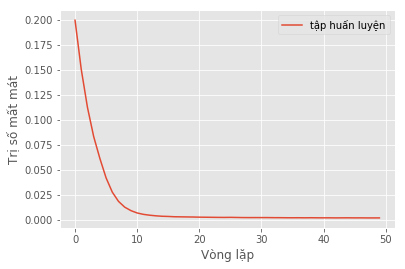

In [125]:
plt.plot(h3.history['loss'], label="tập huấn luyện")
plt.xlabel('Vòng lặp')
plt.ylabel('Trị số mất mát')
plt.legend()
plt.show()

In [126]:
loss = pd.DataFrame({'epochs': range(1, epochs+1),
                     'loss': h3.history['loss']})
loss.to_csv('water-rate-loss.dat', index=False)

In [127]:
water = m3

y_train_pred = water.predict(X_tr3)
y_test_pred = water.predict(X_te3)

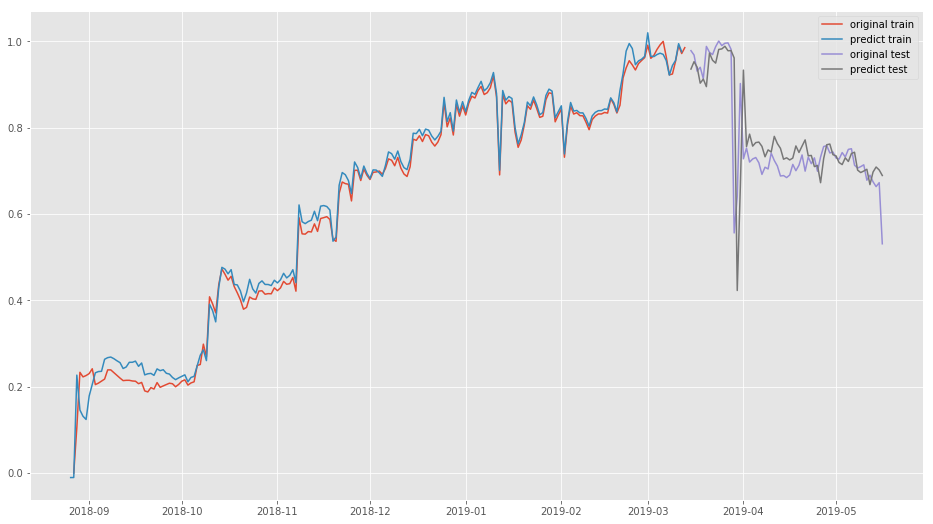

In [128]:
plt.figure(figsize=(16, 9))
plt.plot(w3['date'][1:200], y_tr3, label='original train')
plt.plot(w3['date'][:199], y_train_pred, label='predict train')
plt.plot(w3['date'][201:], y_te3, label='original test')
plt.plot(w3['date'][201:], y_test_pred, label='predict test')
plt.legend()
plt.show()

In [129]:
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_test_pred, y_te3), MAPE(y_test_pred, y_te3)))

MSE: 0.0064 | MAPE: 0.1530


In [134]:
water.save('water-rate-loss-0.0064.hdf5')

In [130]:
# water = load_model('water-rate-loss-0.0098.hdf5')

y_train_pred = water.predict(X_tr3)
y_test_pred = water.predict(X_te3)

y_hat = inverse(scaler, X_te3[:, :-1], y_test_pred)
y_train_hat = inverse(scaler, X_tr3[:, :-1], y_train_pred)

In [135]:
predict_train_set = pd.DataFrame({'date': w3['date'][1:200].values,
                                  'orig': mtrain['q_water'][1:200].values,
                                  'pred': y_train_hat})

predict_test_set = pd.DataFrame({'date': w3['date'][201:].values,
                                 'orig': mtest['q_water'][1:].values,
                                 'pred': y_hat})

predict_train_set.to_csv('water_train.dat', index=False)
predict_test_set.to_csv('water_test.dat', index=False)

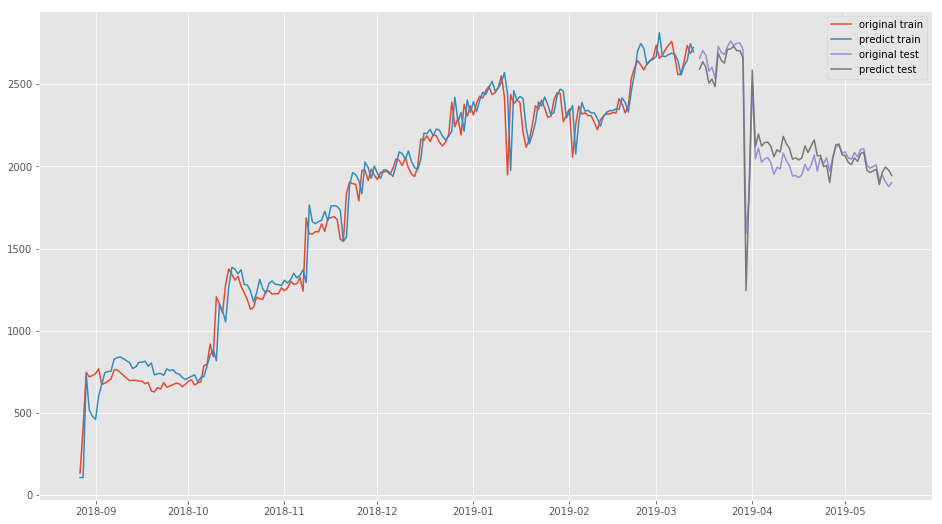

In [131]:
plt.figure(figsize=(16, 9))
plt.plot(w3['date'][1:200], mtrain['q_water'][1:200], label='original train')
plt.plot(w3['date'][1:200], y_train_hat, label='predict train')
plt.plot(w3['date'][201:],  mtest['q_water'][:-1], label='original test')
plt.plot(w3['date'][201:],  y_hat, label='predict test')
plt.legend()
plt.show()

In [132]:
m = test2['q_water'][:-1].values
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_hat, m), MAPE(y_hat, m)))

MSE: 6824.3007 | MAPE: 0.0319


In [133]:
np.sqrt(mse(y_hat, m))

82.60932557679766

## OIL RATE

In [136]:
train3 = pd.concat([mtrain.drop(['q_oil'], axis=1), mtrain['q_oil']], axis=1)
test3 = pd.concat([mtest.drop(['q_oil'], axis=1), mtest['q_oil']], axis=1)

In [137]:
scaler, train, test = scale(train3, test3)
cols = train3.columns
df = to_DF(cols, train, test)
train, test = df[0], df[1]
print(train.shape, test.shape)

(200, 6) (64, 6)


In [138]:
vf_oil = test.values[-1].reshape((1, -1))
vf_oil

array([[0.32768362, 0.5311395 , 0.21085791, 0.27104058, 0.65462428,
        0.33526803]])

In [139]:
X_tr4, y_tr4 = shift(train, 'q_oil', step=1)
X_te4, y_te4 = shift(test, 'q_oil', step=1)
print(X_tr4.shape, y_tr4.shape, X_te4.shape, y_te4.shape)

(199, 6) (199,) (63, 6) (63,)


In [161]:
m4 = Sequential()
m4.add(Dense(7, input_shape=(6, ), activation='linear'))
m4.add(LeakyReLU(alpha=0.001))
m4.add(Dense(1))
m4.compile(loss='mse', optimizer='adam')

In [162]:
epochs = 50

h4 = m4.fit(X_tr4, y_tr4, 
             epochs=epochs,
             batch_size=4)

Epoch 1/50
199/199 [==============================] - 1s 5ms/step - loss: 0.5443
Epoch 2/50
199/199 [==============================] - 0s 623us/step - loss: 0.1941
Epoch 3/50
199/199 [==============================] - 0s 623us/step - loss: 0.1024
Epoch 4/50
199/199 [==============================] - 0s 618us/step - loss: 0.0761
Epoch 5/50
199/199 [==============================] - 0s 633us/step - loss: 0.0603
Epoch 6/50
199/199 [==============================] - 0s 623us/step - loss: 0.0479
Epoch 7/50
199/199 [==============================] - 0s 618us/step - loss: 0.0381
Epoch 8/50
199/199 [==============================] - 0s 623us/step - loss: 0.0301
Epoch 9/50
199/199 [==============================] - 0s 663us/step - loss: 0.0234
Epoch 10/50
199/199 [==============================] - 0s 613us/step - loss: 0.0179
Epoch 11/50
199/199 [==============================] - 0s 628us/step - loss: 0.0137
Epoch 12/50
199/199 [==============================] - 0s 623us/step - loss: 0.0105
Epo

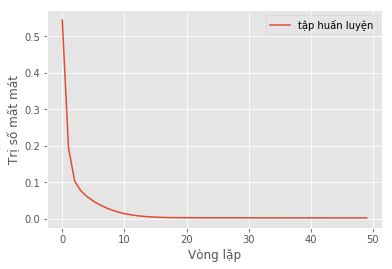

In [163]:
plt.plot(h4.history['loss'], label="tập huấn luyện")
plt.xlabel('Vòng lặp')
plt.ylabel('Trị số mất mát')
plt.legend()
plt.show()

In [164]:
loss = pd.DataFrame({'epochs': range(1, epochs+1),
                    'loss': h4.history['loss']})
loss.to_csv('w3-oil-loss.dat', index=False)

In [165]:
oil = m4

y_train_pred = oil.predict(X_tr4)
y_test_pred = oil.predict(X_te4)

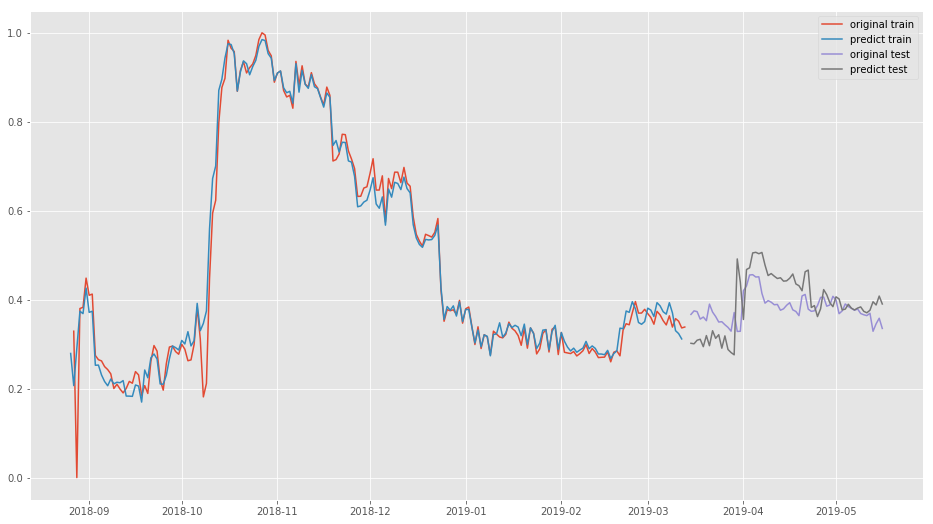

In [166]:
plt.figure(figsize=(16, 9))
plt.plot(w3['date'][1:200], y_tr4, label='original train')
plt.plot(w3['date'][:199], y_train_pred, label='predict train')
plt.plot(w3['date'][201:], y_te4, label='original test')
plt.plot(w3['date'][201:], y_test_pred, label='predict test')
plt.legend()
plt.show()

In [167]:
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_test_pred, y_te4), MAPE(y_test_pred, y_te4)))

MSE: 0.0031 | MAPE: 0.1568


In [168]:
# oil.save('oil-rate-loss-0.0032.hdf5')

In [173]:
oil = load_model('oil-rate-loss-0.0032.hdf5')

y_train_pred = oil.predict(X_tr4)
y_test_pred = oil.predict(X_te4)

y_hat = inverse(scaler, X_te4[:, :-1], y_test_pred)
y_train_hat = inverse(scaler, X_tr4[:, :-1], y_train_pred)

In [174]:
predict_train_set = pd.DataFrame({'date': w3['date'][1:200].values,
                                  'orig': mtrain['q_oil'][1:200].values,
                                  'pred': y_train_hat})

predict_test_set = pd.DataFrame({'date': w3['date'][201:].values,
                                 'orig': mtest['q_oil'][1:].values,
                                 'pred': y_hat})

predict_train_set.to_csv('oil_train.dat', index=False)
predict_test_set.to_csv('oil_test.dat', index=False)

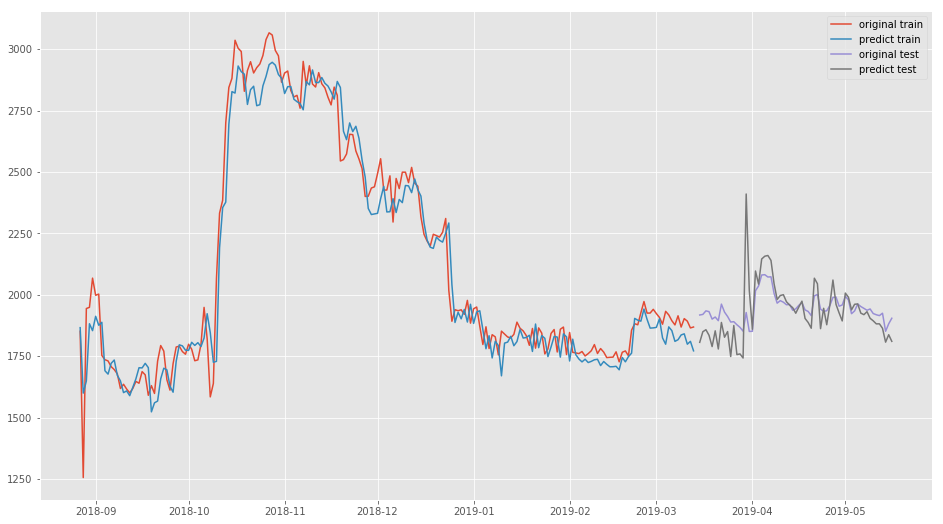

In [175]:
plt.figure(figsize=(16, 9))
plt.plot(w3['date'][1:200], mtrain['q_oil'][1:200], label='original train')
plt.plot(w3['date'][1:200], y_train_hat, label='predict train')
plt.plot(w3['date'][201:],  mtest['q_oil'][:-1], label='original test')
plt.plot(w3['date'][201:],  y_hat, label='predict test')
plt.legend()
plt.show()

In [176]:
m = test3['q_oil'][:-1].values
print('MSE: {:.4f} | MAPE: {:.4f}'.format(mse(y_hat, m), MAPE(y_hat, m)))

MSE: 7786.1129 | MAPE: 0.0302


## PREDICT

In [33]:
whft = load_model('whft-loss-0.0061.hdf5')
pred = whft.predict(vf_whft)
whft_future = inverse(scaler, vf_whft[:, :-1], pred)

In [34]:
whft_future

array([88.4045434])

In [39]:
whfp = load_model('whfp-loss-0.0042.hdf5')
pred = whfp.predict(vf_whfp)
whfp_future = inverse(scaler, vf_whfp[:, :-1], pred)

In [40]:
whfp_future

array([264.10053634])

In [45]:
water = load_model('water-rate-loss-0.0052.hdf5')
pred = water.predict(vf_water)
water_rate_future = inverse(scaler, vf_water[:, :-1], pred)

In [46]:
water_rate_future

array([1584.65485242])

In [94]:
oil = load_model('oil-rate-loss-0.0005.hdf5')
pred = oil.predict(vf_oil)
oil_rate_future = inverse(scaler, vf_oil[:, :-1], pred)

In [95]:
oil_rate_future

array([1905.25176933])

In [178]:
t = whft.layers[1].get_weights()[0].reshape((1, -1))
p = whfp.layers[2].get_weights()[0].reshape((1, -1))
qw = water.layers[2].get_weights()[0].reshape((1, -1))
qo = oil.layers[2].get_weights()[0].reshape((1, -1))
weight = np.r_[qo, qw, t, p]
bias = np.r_[oil.layers[2].get_weights()[1], water.layers[2].get_weights()[1],\
             whft.layers[1].get_weights()[1], whfp.layers[2].get_weights()[1]].reshape((-1, 1))
q = np.c_[weight, bias]
x = pd.DataFrame(data=q, columns=['1', '2', '3', '4', '5', '6', '7', 'bias'])

In [180]:
x.to_csv('w3-weight.csv', index=False)